численное решение уравнения диффузии

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import scipy as scipy

#from tqdm import tqdm_notebook
import time

from tqdm import tqdm

In [103]:
class Diffusion:
    # сетки
    def __init__(self):
        return
        
    def solve(self, Dp):
        L = 1
        Nx = 11
        self.Nx = Nx
        Nt = 1001
        self.Nt = Nt
        T_end = 100
        self.x = np.linspace(0,L,Nx)
        
        left_cond = 1 # слева concentration
        right_cond = -1 # справа значение концентрации
        CTR_0 = -10
        
        # parameters
        CTR = np.zeros((Nx, Nt))
        D = np.zeros((Nx,Nt))
        for j in range(Nt):
            D[:,j] = Dp[j*Nx:(j+1)*Nx]
        
        #print(np.shape(D))
        # boundaries
        CTR[:,0] = CTR_0
        #CTR[:,0] = np.sin(self.x)
        CTR[0,:] = left_cond
        CTR[Nx-1,0] = right_cond
        
        
        A = np.zeros((Nx,Nx, Nt))
        b = np.zeros((Nx, Nt))
        b1 = np.zeros((Nx,Nx, Nt))
        
        dd = (L / (Nx-1))**2 / (T_end / (Nt - 1))
        
        
        for j in range(Nt-1):
        
            A[0,0,j] = 1
            A[Nx-1,Nx-1,j] = 1
            b[0,j] = CTR[0,j]
            b[Nx-1,j] = CTR[Nx-1,j]
            b1[0,0,j] = 1
            b1[Nx-1,Nx-1,j] = 1
            
            for i in range(1,Nx-1):
                A[i,i,j] = - (D[i,j] + D[i+1,j] + dd)
                A[i,i+1,j] = D[i+1,j]
                b[i,j] = - dd * CTR[i,j]
                b1[i,i,j] = - dd
            for i in range(0,Nx-2):
                A[i+1,i,j] = D[i,j]
            
            CTR[:,j+1] = np.linalg.solve(A[:,:,j], b[:,j])
            
    
        
        self.solution = CTR
        return CTR, A, b, b1
    
    def cf_grad(self, D):
        Nx = self.Nx
        Nt = self.Nt
        C_fix = self.C_fix

        lam = np.zeros((Nx,Nt))
        CTR, A, b, b1 = self.solve(D) 
        
        #D = self.get_D(D)
        
        lam[:,Nt-1] = -(CTR[:,Nt-1] - C_fix[:,Nt-1]).T @ np.linalg.inv(A[:,:,Nt-2]) # Ваня ищет оператор
        
        
        for j in range(Nt-2,0,-1):
            lam[:,j] = - ((CTR[:,j] - C_fix[:,j]) + lam[:,j+1] @ (b1[:,:,j])) @ np.linalg.inv(A[:,:,j-1])

        
        #print(lam[:, Nt-1])
        #print(lam[:, 10])
        #print(lam[:, 20])
        gu = np.zeros((Nx,Nx,Nt))
        
        for j in range(Nt-1):
            gu[0,0,j] = - CTR[0,j+1]
            gu[Nx-1,Nx-1,j] = -CTR[Nx-1,j+1]
            for i in range(1,Nx-1):
                gu[i,i,j] = CTR[i-1,j+1] - CTR[i,j+1]
                gu[i,i+1,j] = CTR[i+1,j+1] - CTR[i,j+1]
        
                
        grad = np.zeros(Nx * Nt)
        for j in range(Nt-1):
            grad[j*Nx:(j+1)*Nx] = lam[:,j+1] @ gu[:,:,j]
        
        grad = grad / np.linalg.norm(grad)
        
        return grad
            
            
    
    def cost_function(self, D):
        sol, _,_,_ = self.solve(D)
        val = 0
        for j in range(self.Nt):
            val += (np.linalg.norm(sol[:,j] - self.C_fix[:,j]))**2
        #print(f"val = {val}")
        return val / 2
    
    
    def initialize(self, C_fix):
        
        self.C_fix = C_fix
    
    def plot(self, timesteps):
        [plt.plot(self.x, self.solution[:,tp], ) for tp in timesteps]
        plt.show()
        
        
    def get_D(self, value):
        
        
        
        
        D = np.zeros((self.Nx, self.Nt))
        
        if np.isscalar(value) == True:
            D = D + value
        
        else:
            for j in range(self.Nt):
                    D[:,j] = value
                
        
        return D

In [104]:
slvr = Diffusion()
x=np.linspace(0,1,11)
Dp =np.sin(x)
D = np.zeros(11*1001)
for j in range(1001):
    D[j*11:(j+1)*11] = Dp
#D = 0.6 * np.ones(101)
%time slvr1 = Diffusion()

Wall time: 0 ns


In [105]:
%time C1, A, b, b1 = slvr.solve(D)
%time Cfix, A, b, b1 = slvr1.solve(D)

Wall time: 41.9 ms
Wall time: 32.9 ms


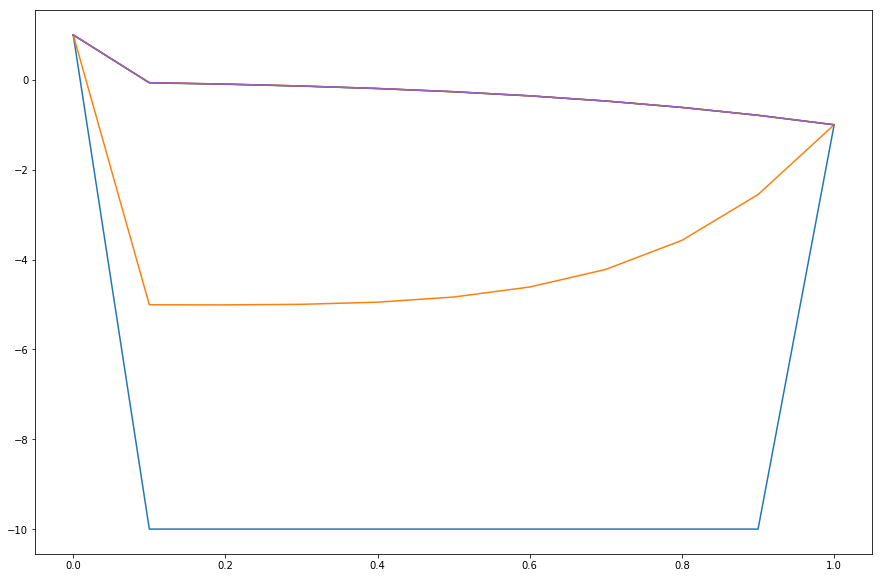

In [106]:

plt.figure()
slvr1.plot([0, 1, 10, 100, 1000])

In [107]:
slvr.initialize(Cfix)

In [108]:
jaco = slvr.cf_grad(D+1)

In [109]:
jaco

array([ 0.07528563,  0.40581138,  0.0660178 , ...,  0.        ,
        0.        ,  0.        ])

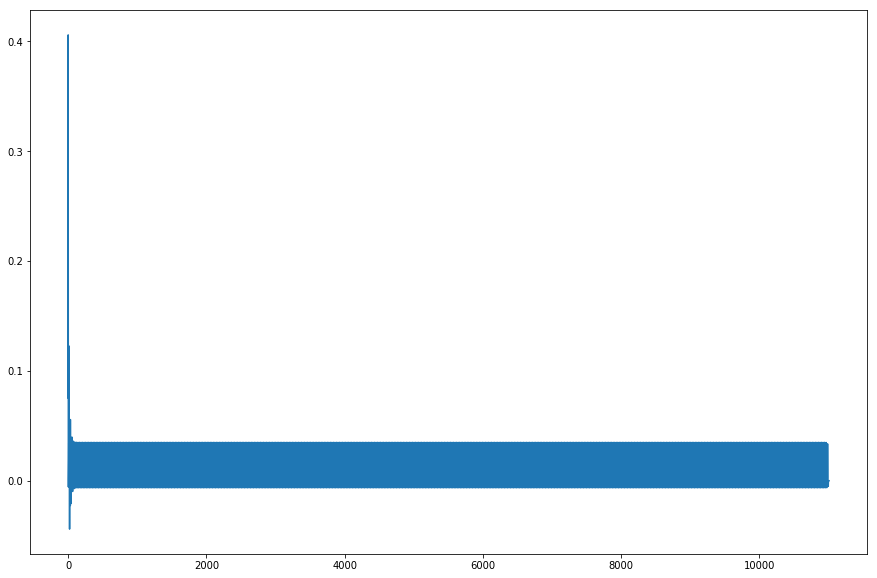

In [110]:
_ = plt.plot(jaco)

In [111]:
np.linalg.norm(jaco)

0.99999999999999989

In [156]:
bb = np.random.random(size=len(D))

x0 = D + bb - D.mean()

In [157]:
D.mean()

0.45580736190761012

In [158]:
np.shape(D)

(11011,)

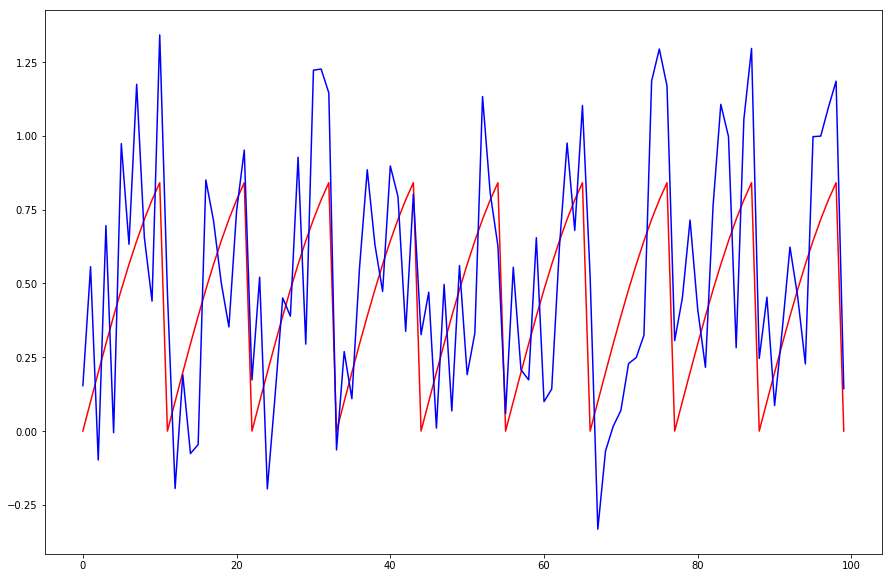

In [159]:
plt.figure()
plt.plot(D[:100], 'r')
plt.plot(x0[:100], 'b')

In [160]:
def GradientDescent(f, gradf, x0,  num_iter, eps, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
        
    iteration = 1

    ch = 0
    less = False
    alpha = 1
    x_new = np.zeros(len(x_prev))
    while True:
        gradient = gradf(x_prev)
        ll = np.shape(gradient)
        #x_new = np.zeros(len)
    
        if less == True:
            alpha *= 0.5
            
        
        x_new = x_prev - alpha * gradient
        
        gain = (x_new - x_prev) / x_prev
        
        if np.linalg.norm(gain) < eps:
            print(f"gain less that {eps}")
            break
        
        if (f(x_new) - f(x_prev)) < 0:
            x_prev = x_new
            print("Current function val =", f(x_prev))
            less = False
        else:
            less = True
            
        iteration += 1

        if iteration >= num_iter:
            break
            
        #print("grad sign =", np.sign(gradf(x_prev) * gradf(x_new)))
        #print(f"x = {x}")
    #res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    res = x_prev
    return res

In [161]:
%time res = GradientDescent(f = slvr.cost_function, x0=x0, gradf=slvr.cf_grad, num_iter=50000, eps=1e-6)

Current function val = 11405.1460883
Current function val = 6476.92599133
Current function val = 3645.0575299
Current function val = 1230.16513911
Current function val = 826.601133769
Current function val = 693.782197486
Current function val = 599.198584886
Current function val = 530.971213867
Current function val = 499.837944257
Current function val = 487.841318221
Current function val = 465.076540021
Current function val = 451.142932436
Current function val = 440.055303323
Current function val = 431.833761134
Current function val = 425.481638147
Current function val = 425.034406896
Current function val = 424.996142032
Current function val = 414.071091731
Current function val = 413.021744489
gain less that 1e-06
Wall time: 7.14 s


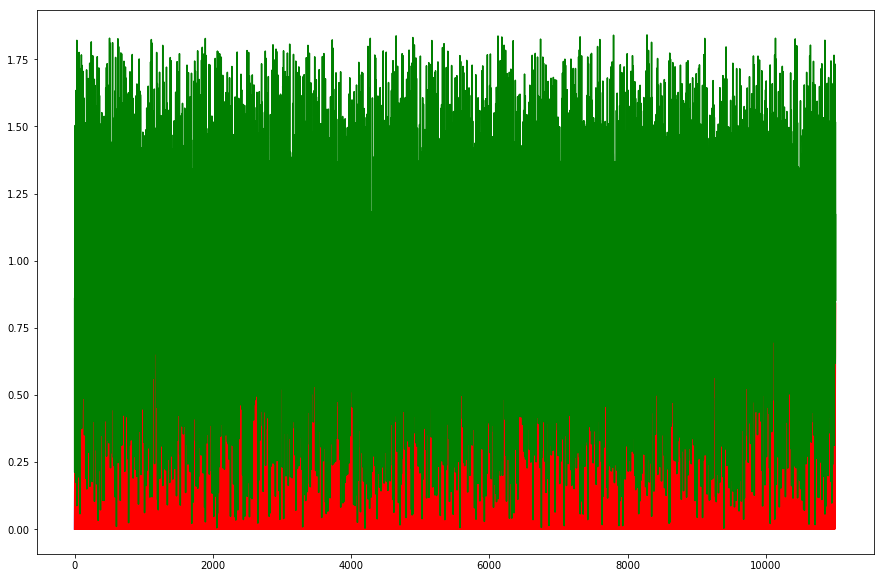

In [132]:
plt.figure()
_ = plt.plot(x, 'b')
_ = plt.plot(D, 'r')
_ = plt.plot(x0, 'g')

In [131]:
"""class Levenberg_Marquardt:
    
    def __init__(self, f, gradf, x0, max_iter):
        self.f = f
        self.gradf = gradf
        self.x0=x0
        #self.epsilon = epsilon
        self.max_iter = max_iter
        
    def find_solution(self):
        
        ##############
        ####CHEAT
        ll = np.shape(self.x0)
        
        
        def get_A(x, j):
            return ((self.gradf(x))[:,j]) @ ((self.gradf(x))[:,j]).T
        
        def get_g(x, j):
            #print(f"self.f(x) = {self.f(x)}")
            return ((self.gradf(x))[:,j]) * self.f(x[:,j])
        
        def get_direction(A, g):
            #print(f"A = {np.shape(A)}")
            #print(f"npdiag = {np.shape(np.diag(np.diag(A)))}")
            #rint(f"mu = {np.shape(mu)}")
            left = A + mu * np.diag(np.diag(A))
            right = - g
            #print(f"A = {A}")
            pk = np.linalg.solve(left, right)
            return pk
        
        def get_gain(x_new, x_prev, pk):
            gain = np.zeros(ll[1])
            delimiter = np.zeros(ll[1])
            
            grad = self.gradf(x_prev)
            fx_prev = self.f(x_prev)
            
            numerator = fx_prev - self.f(x_new)
            
            for j in range(ll[1]):
                a = time.time()
                #print(f"vlv = {pk[:,j].T @ (mu * pk[:,j] + (self.gradf(x_prev))[:,j] * self.f(x_prev))}")
                delimiter[j] = pk[:,j].T @ (mu * pk[:,j] + (grad)[:,j] * fx_prev)
                #print(f" 1 time step = {time.time() - a}")
                gain[j] = numerator / delimiter[j]
                
                
            return gain
        
        
        
        x_prev = self.x0
        in_A = get_A(x_prev)
        mu = 1e-3 * (np.matrix(in_A)).max()
            
        v = 2
        iters = 0
        while iters < self.max_iter:
            
            A = get_A(x_prev)
            g = get_g(x_prev)
            
            pk = get_direction(A,g)
            
            x_new = x_prev + pk
            
            gain = get_gain(x_new, x_prev, pk)
            
            if np.all(gain) >= 0:
                x_prev = x_new
                mu = mu * np.maximum(1/3, 1 - (2*np.amax(gain) - 1)**3)
                v = 2
            else:
                mu *= v
                v *= v
                
            print("Current function val =", self.f(x_new))
            iters += 1
                
        return x_prev"""
                
        
        


'class Levenberg_Marquardt:\n    \n    def __init__(self, f, gradf, x0, max_iter):\n        self.f = f\n        self.gradf = gradf\n        self.x0=x0\n        #self.epsilon = epsilon\n        self.max_iter = max_iter\n        \n    def find_solution(self):\n        \n        ##############\n        ####CHEAT\n        ll = np.shape(self.x0)\n        \n        \n        def get_A(x, j):\n            return ((self.gradf(x))[:,j]) @ ((self.gradf(x))[:,j]).T\n        \n        def get_g(x, j):\n            #print(f"self.f(x) = {self.f(x)}")\n            return ((self.gradf(x))[:,j]) * self.f(x[:,j])\n        \n        def get_direction(A, g):\n            #print(f"A = {np.shape(A)}")\n            #print(f"npdiag = {np.shape(np.diag(np.diag(A)))}")\n            #rint(f"mu = {np.shape(mu)}")\n            left = A + mu * np.diag(np.diag(A))\n            right = - g\n            #print(f"A = {A}")\n            pk = np.linalg.solve(left, right)\n            return pk\n        \n        def get_

In [ ]:
"""x0 = np.zeros((11,1001)) + 0.1"""

In [130]:
"""optimiz = Levenberg_Marquardt(f=slvr.cost_function, x0 = x0, gradf=slvr.cf_grad, max_iter=20)"""

'optimiz = Levenberg_Marquardt(f=slvr.cost_function, x0 = x0, gradf=slvr.cf_grad, max_iter=20)'